# TEXT CLASSIFICATION WITH THE TORCHTEXT LIBRARY
### In this tutorial, we will show how to use the torchtext library to build the dataset for the text classification analysis. Users will have the flexibility to

  - Access to the raw data as an iterator

  - Build data processing pipeline to convert the raw text strings into torch.Tensor that can be used to train the model

  - Shuffle and iterate the data with [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

### Prerequisites
A recent 2.x version of the portalocker package needs to be installed prior to running the tutorial.

In [1]:
!pip install -U portalocker

### Access to the raw dataset iterators
The torchtext library provides a few raw dataset iterators, which yield the raw text strings. For example, the AG_NEWS dataset iterators yield the raw data as a tuple of label and text.

To access torchtext datasets, please install torchdata following instructions [here](https://github.com/pytorch/data).

In [2]:
!pip install -U torchtext

In [4]:
import torch
from torchtext.datasets import AG_NEWS

train_iter = iter(AG_NEWS(split="train"))
type(train_iter)

generator

In [5]:
next(train_iter)

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

In [6]:
next(train_iter)

(3,
 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.')

In [7]:
next(train_iter)

(3,
 "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.")

### Prepare data processing pipelines
We have revisited the very basic components of the torchtext library, including vocab, word vectors, tokenizer. Those are the basic data processing building blocks for raw text string.

Here is an example for typical NLP data processing with tokenizer and vocabulary. The first step is to build a vocabulary with the raw training dataset. Here we use built in factory function build_vocab_from_iterator which accepts iterator that yield list or iterator of tokens. Users can also pass any special symbols to be added to the vocabulary.

In [11]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")
train_iter = AG_NEWS(split="train")


def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

The vocabulary block converts a list of tokens into integers.

In [12]:
vocab(['here', 'is', 'an', 'example'])

[475, 21, 30, 5297]

Prepare the text processing pipeline with the tokenizer and vocabulary. The text and label pipelines will be used to process the raw data strings from the dataset iterators.

In [13]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

The text pipeline converts a text string into a list of integers based on the lookup table defined in the vocabulary. The label pipeline converts the label into integers. For example,

In [14]:
text_pipeline('here is the an example')

[475, 21, 2, 30, 5297]

In [15]:
label_pipeline('10')

9

### Generate data batch and iterator
[torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) is recommended for PyTorch users (a tutorial is [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)). It works with a map-style dataset that implements the getitem() and len() protocols, and represents a map from indices/keys to data samples. It also works with an iterable dataset with the shuffle argument of False.

Before sending to the model, collate_fn function works on a batch of samples generated from DataLoader. The input to collate_fn is a batch of data with the batch size in DataLoader, and collate_fn processes them according to the data processing pipelines declared previously. Pay attention here and make sure that collate_fn is declared as a top level def. This ensures that the function is available in each worker.

In this example, the text entries in the original data batch input are packed into a list and concatenated as a single tensor for the input of nn.EmbeddingBag. The offset is a tensor of delimiters to represent the beginning index of the individual sequence in the text tensor. Label is a tensor saving the labels of individual text entries.

In [16]:
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)


train_iter = AG_NEWS(split="train")
dataloader = DataLoader(
    train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch
)

### Define the model
The model is composed of the [nn.EmbeddingBag](https://pytorch.org/docs/stable/nn.html#torch.nn.EmbeddingBag) layer plus a linear layer for the classification purpose. nn.EmbeddingBag with the default mode of “mean” computes the mean value of a “bag” of embeddings. Although the text entries here have different lengths, nn.EmbeddingBag module requires no padding here since the text lengths are saved in offsets.

Additionally, since nn.EmbeddingBag accumulates the average across the embeddings on the fly, nn.EmbeddingBag can enhance the performance and memory efficiency to process a sequence of tensors.

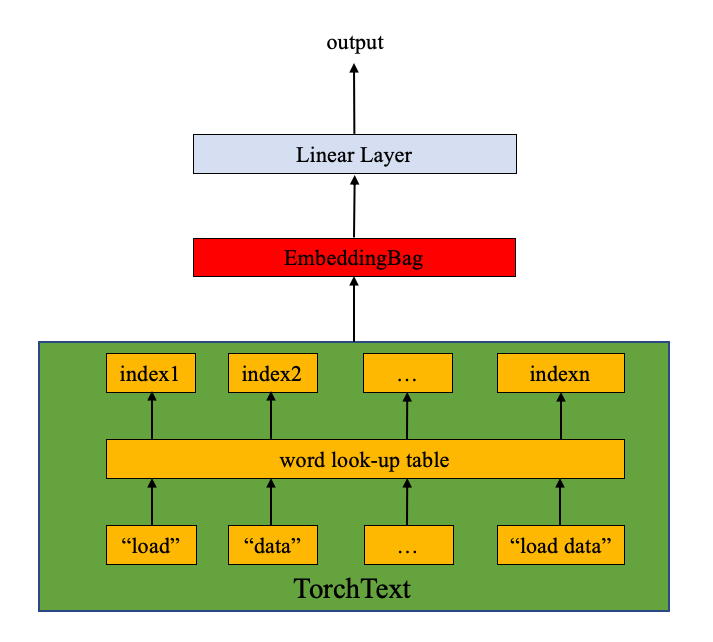

In [17]:
from torch import nn


class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

### Initiate an instance
The AG_NEWS dataset has four labels and therefore the number of classes is four.

1 : World
2 : Sports
3 : Business
4 : Sci/Tec<br>

We build a model with the embedding dimension of 64. The vocab size is equal to the length of the vocabulary instance. The number of classes is equal to the number of labels,

In [23]:
train_iter = AG_NEWS(split="train")
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
embedding_dimension_size = 64
model = TextClassificationModel(vocab_size, embedding_dimension_size, num_class).to(device)
set([label for (label, text) in train_iter])

{1, 2, 3, 4}

### Define functions to train the model and evaluate results.

In [24]:
import time


def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()


def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

### Split the dataset and run the model
Since the original AG_NEWS has no valid dataset, we split the training dataset into train/valid sets with a split ratio of 0.95 (train) and 0.05 (valid). Here we use [torch.utils.data.dataset.random_split](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split) function in PyTorch core library.

[CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss) criterion combines nn.LogSoftmax() and nn.NLLLoss() in a single class. It is useful when training a classification problem with C classes. [SGD](https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html) implements stochastic gradient descent method as the optimizer. The initial learning rate is set to 5.0. [StepLR](https://pytorch.org/docs/master/_modules/torch/optim/lr_scheduler.html#StepLR) is used here to adjust the learning rate through epochs.

In [25]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

# Hyperparameters
EPOCHS = 10  # epoch
LR = 5  # learning rate
BATCH_SIZE = 64  # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = random_split(
    train_dataset, [num_train, len(train_dataset) - num_train]
)

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print("-" * 59)
    print(
        "| end of epoch {:3d} | time: {:5.2f}s | "
        "valid accuracy {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, accu_val
        )
    )
    print("-" * 59)

| epoch   1 |   500/ 1782 batches | accuracy    0.684
| epoch   1 |  1000/ 1782 batches | accuracy    0.859
| epoch   1 |  1500/ 1782 batches | accuracy    0.876
-----------------------------------------------------------
| end of epoch   1 | time:  7.95s | valid accuracy    0.891 
-----------------------------------------------------------
| epoch   2 |   500/ 1782 batches | accuracy    0.898
| epoch   2 |  1000/ 1782 batches | accuracy    0.903
| epoch   2 |  1500/ 1782 batches | accuracy    0.903
-----------------------------------------------------------
| end of epoch   2 | time:  7.92s | valid accuracy    0.899 
-----------------------------------------------------------
| epoch   3 |   500/ 1782 batches | accuracy    0.913
| epoch   3 |  1000/ 1782 batches | accuracy    0.914
| epoch   3 |  1500/ 1782 batches | accuracy    0.914
-----------------------------------------------------------
| end of epoch   3 | time:  8.09s | valid accuracy    0.908 
-------------------------------

### Evaluate the model with test dataset
Checking the results of the test dataset…

In [26]:
print("Checking the results of test dataset.")
accu_test = evaluate(test_dataloader)
print("test accuracy {:8.3f}".format(accu_test))

Checking the results of test dataset.
test accuracy    0.910


### Test on a random news
Use the best model so far and test a golf news.

In [27]:
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}


def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1


ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

model = model.to("cpu")

print("This is %s news" % ag_news_label[predict(ex_text_str, text_pipeline)])

This is Sports news
